# Mutual information between demographics and browser attributes


#### Research question:
Beyond uniquely identifying users, can fingerprinting strategies be used to infer user demographics?

If this is the case, which browser attributes, for which demographic groups, make this easier?

To study this we use [mutual information](https://en.wikipedia.org/wiki/Mutual_information).

For a given demographic category, D, (e.g. "Income") and given browser attribute, A, (e.g. "Device memory"):

We consider these random variables and compute mutual information for I(D; A) using log base 2.


We produce a table representing the mutual information for each attribute and demographic category pair.

```
Attribute, Gender, Age, Hispanic, Race, Income
...
```

Please excuse the below abuse of notation, where A and D stand for both sets names for Attributes and Demographic categories.


An important implementation detail is how the groups within these demographic categories are defined:
- We use Gender:{Male, Female, Other} (rather than leaving out Gender:Other)
- We aggregate the 6 age and income groups to 3 age and income groups, but also keep income: 'Prefer not to say', making 4 income groups in total.

Another important implementation detail is `k`. We drop all values corresponding to device attributes appearing less than k times.

Since k is an important parameter, we repeat this analysis for k=1, k=50, k=100.

Steps:

For a given attribute, A=$\{a_1, a_2, ...\}$, demographic category, $D=\{d_1, d_2, ...\}$

Create the contingency table: Rows are values $a_i$ in A, columns are values $d_j$ in D, cells are counts of users with $a_i$ and $d_j$.

For a given k, restrict the contingency table to $A_k=\{a_i \in A | n_i >= k\}$ where $n_i$ is the total number of users in the table with attribute $a_i$.

From the (restricted) contingency table, get the distributions as dicts
- $P(A_k)$ = {$a_i$: $p(a_i)$ for $a_i$ in $A_k$}
- $P(D)$ = {$d_j: p(d_j)$ for $d_j$ in D}
- $P(A_k, D)$ = {$(a_i, d_j)$: $p(a_i, d_j)$ for $a_i$ in $A_k$, for $d_j$ in $D$}

From this we compute mutual information $I(A_k; D)$:

$I(A_k; D) = \sum_{a}{\sum_{d}{p(a,d) log(\frac{p(a,d)}{p(a)p(d)})}}$

And compute "normalized" mutual information:

$NMI(A_k;D) = \frac{I(A_k; D)}{H(D)}$ where $H(D)$ is Shannon entropy computed over $D$.

There are tests further below that compare non-normalized I to normalized NMI.
In addition, we compare this to another "normalized" version that also noramlizes of the entropy of A. i.e.

$NMI(A_k;D) = \frac{I(A_k; D)}{\sqrt{H(A_k)H(D)}}$ where $H(D), H(A)$ are Shannon entropy computed over $D$ and $A$.

In [ ]:
import math

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from google.colab import drive

drive_path = '/content/drive/' # don't change this or try to combine with fpath
drive.mount(drive_path)#, force_remount=True)
drive_fpath = '/content/drive/MyDrive/fingerprinting-data-analysis'

# view all the columns
pd.set_option('display.max_columns', None)

# This file is available via github but there are bandwidth limits on git LFS
# so I also copied it to this drive.
survey_and_browser_attrs_fpath = drive_fpath + '/survey-and-browser-attributes-data.txt'
# survey_and_browser_attrs_fpath = 'https://media.githubusercontent.com/media/aberke/fingerprinting-study/master/data/survey-and-browser-attributes-data.csv'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Browser attributes data

We replace NaN values with the empty string so that these are handled similarly and so that empty values are captured by calls to `value_counts` (NaN values are not).

We keep only the columns for participant demographic and browser attributes that we wish to study.

We only use browser attributes we consider stable for fingerprinting.

In [ ]:
demos_cols = [
    'Q-demos-age', 'Q-demos-gender', 'Q-demos-hispanic', 'Q-demos-race', 'Q-demos-income',
]
stable_ba_names = [
    'User agent', 'Languages', # Can be collected passively via HTTP headers
    'Timezone', 'Screen resolution',
    'Color depth', 'Platform', 'Touch points',
    'Hardware concurrency', 'Device memory',
    'WebGL Vendor', 'WebGL Unmasked Vendor',
    'WebGL Renderer', 'WebGL Unmasked Renderer',
]

In [ ]:
# Replace nan values with the empty string
sba_df = pd.read_csv(
    survey_and_browser_attrs_fpath, usecols=['ResponseId']+demos_cols+stable_ba_names
).set_index('ResponseId').fillna('')
# Rename some columns
sba_df = sba_df.rename(columns={
    'Q-demos-age': 'Age',
    'Q-demos-gender': 'Gender',
    'Q-demos-hispanic': 'Hispanic',
    'Q-demos-race': 'Race',
    'Q-demos-income': 'Income',
})
N = len(sba_df)
print('N=%s'%N)
# sba_df.head(3)

N=8400


We apply some transformations to the demographics in order to make the data easier to analyze.

In [ ]:
# map race to shorter names and aggregate other and mixed to 'Other or mixed'
race_names_map = {
    'White or Caucasian': 'White',
    'Black or African American': 'Black',
    'Asian': 'Asian'
    # All others we map to 'Other or mixed'
    # 'Native Hawaiian or Other Pacific Islander': no participants in our dataset
    # 'American Indian/Native American or Alaska Native': too few participants in our dataset
}
sba_df['Race'] = sba_df['Race'].apply(lambda r: race_names_map[r] if r in race_names_map else 'Other or mixed')
sba_df['Race'].value_counts()

White             5911
Black              938
Asian              842
Other or mixed     709
Name: Race, dtype: int64

In [ ]:
# Make reduced versions of Age and Income demographics, mapping 6 categories to 3
sba_df['Age'] = sba_df['Age'].map({
    '18 - 24 years': '18 - 34 years',
    '25 - 34 years': '18 - 34 years',
    '35 - 44 years': '35 - 54 years',
    '45 - 54 years': '35 - 54 years',
    '55 - 64 years': '55 or older',
    '65 or older': '55 or older',
})
sba_df['Income'] = sba_df['Income'].map({
    'Less than $25,000': 'Less than $50,000',
    '$25,000 - $49,999': 'Less than $50,000',
    '$50,000 - $74,999': '$50,000 - $99,999',
    '$75,000 - $99,999': '$50,000 - $99,999',
    '$100,000 - $149,999': '$100,000 or more',
    '$150,000 or more': '$100,000 or more',
    'Prefer not to say': 'Prefer not to say'
})
print('Reduced age and income:')
print('Age')
display(sba_df['Age'].value_counts().sort_index())
print('Income')
display(sba_df['Income'].value_counts().sort_index())

Reduced age and income:
Age


18 - 34 years    4161
35 - 54 years    3182
55 or older      1057
Name: Age, dtype: int64

Income


$100,000 or more     2362
$50,000 - $99,999    2959
Less than $50,000    2939
Prefer not to say     140
Name: Income, dtype: int64

In [ ]:
# Setup
Ds = {
    'Gender': ['Male','Female','Other'],
    'Age': sorted(sba_df['Age'].unique()),
    'Hispanic': ['Yes', 'No'],
    'Race': ['White','Black','Asian','Other or mixed'],
    'Income': ['Less than $50,000', '$50,000 - $99,999', '$100,000 or more', 'Prefer not to say'], # sorted
}
Ds

{'Gender': ['Male', 'Female', 'Other'],
 'Age': ['18 - 34 years', '35 - 54 years', '55 or older'],
 'Hispanic': ['Yes', 'No'],
 'Race': ['White', 'Black', 'Asian', 'Other or mixed'],
 'Income': ['Less than $50,000',
  '$50,000 - $99,999',
  '$100,000 or more',
  'Prefer not to say']}

## Compute mutual information



In [ ]:
from scipy.stats import entropy # shannon entropy


def get_contingency_table(df, A_name, D_name):
  """
  Returns a contingency table with index (rows) values of A, columns values of D.
  """
  df[A_name] = df[A_name].astype(str)
  A = df[A_name].value_counts().sort_index().index.tolist()
  D = Ds[D_name]
  return pd.DataFrame({
      **{'Attribute': A},
      **{d: df[df[D_name]==d][A_name].value_counts().sort_index() for d in D}
  }).set_index('Attribute').fillna(0).astype(int)


def get_restricted_contingency_table(table, k):
  """
  Returns table restricted to attribute rows with n >= k.
  Get the total value counts (n) for each attribute value and
  drop attributes with n < k.
  """
  ns = table.sum(axis=1)
  return table.drop(ns[ns < k].index)


def get_distribution_pA(table):
  """Returns the marginal distribution p(A)={a: p(a)} from the contingency table."""
  ns = table.sum(axis=1)
  return (ns/ns.sum()).to_dict()


def get_distribution_pD(table):
  """Returns the marginal distribution p(D)={d: p(d)} from the contingency table."""
  ns = table.sum(axis=0)
  return (ns/ns.sum()).to_dict()


def get_distribution_pAD(table):
  """Returns the join distribution p(A,D)={(a,d): p(a,d)} from the contingency table."""
  N = table.sum().sum()
  td = (table/N).to_dict()
  return {(a,d):p for (d, a_dict) in td.items() for (a, p) in a_dict.items()}


def compute_mutual_information(table, normalized=False, normalized_b=False, normalized_c=False):
  """
  Computes mutual information, I(A;D), in bits (base 2).
  If normalized is True, returns I(A;D)/H(D) where H(D) is Shannon entropy for D.
  If noramlized_b is True, returns I(A;D)/sqrt(H(A)H(D))
  """
  pA = get_distribution_pA(table)
  pD = get_distribution_pD(table)
  pAD = get_distribution_pAD(table)
  # For normalized variant compute entropy
  H_A = entropy(list(pA.values()), base=2)
  H_D = entropy(list(pD.values()), base=2)
  I = 0 # A summation
  for a, p_a in pA.items():
    for d, p_d in pD.items():
      p_ad = pAD[(a,d)]
      if p_ad > 0:
        I += p_ad * math.log((p_ad / (p_a*p_d)), 2) # log base 2
  if normalized:
    return I/H_D
  if normalized_b:
    return I/math.sqrt(H_A*H_D)
  if normalized_c:
    N = table.sum().sum()
    H_M = math.log(N, 2) # normalization denominator for 'normalized entropy'
    return I/math.sqrt(H_M*H_D)
  return I


# Test
A_name = 'Device memory'
D_name = 'Income'
contingency_table = get_contingency_table(sba_df, A_name, D_name)
table = get_restricted_contingency_table(contingency_table, k=1)
assert(round(sum(get_distribution_pA(table).values()), 10) == 1)
assert(round(sum(get_distribution_pD(table).values()), 10) == 1)
assert(round(sum(get_distribution_pAD(table).values()), 10) == 1)
pA = get_distribution_pA(table)
pD = get_distribution_pD(table)
pAD = get_distribution_pAD(table)
I = compute_mutual_information(table)
print('A: %s' % A_name)
print('D: %s' % D_name)
print('p(A):', pA)
print('p(D):', pD)
print('p(A,D):', pAD)
print('I(A;D)=%0.4f'%I)
assert(0<I<1)
norm_I_a = compute_mutual_information(table, normalized=True)
print('(a) normalized I(A;D)=%0.4f'%norm_I_a)
assert(0<norm_I_a<1)
norm_I_b = compute_mutual_information(table, normalized_b=True)
print('(b) normalized I(A;D)=%0.4f'%norm_I_b)
assert(0<norm_I_b<1)
print('N=%s'%table.sum().sum())
print('Contingency table:')
display(table)

A: Device memory
D: Income
p(A): {'': 0.2882142857142857, '0.25': 0.00011904761904761905, '0.5': 0.005238095238095238, '1.0': 0.004404761904761904, '2.0': 0.025595238095238095, '4.0': 0.14202380952380952, '8.0': 0.5344047619047619}
p(D): {'Less than $50,000': 0.3498809523809524, '$50,000 - $99,999': 0.3522619047619048, '$100,000 or more': 0.2811904761904762, 'Prefer not to say': 0.016666666666666666}
p(A,D): {('', 'Less than $50,000'): 0.09392857142857143, ('0.25', 'Less than $50,000'): 0.0, ('0.5', 'Less than $50,000'): 0.0019047619047619048, ('1.0', 'Less than $50,000'): 0.0010714285714285715, ('2.0', 'Less than $50,000'): 0.015357142857142857, ('4.0', 'Less than $50,000'): 0.06666666666666667, ('8.0', 'Less than $50,000'): 0.17095238095238094, ('', '$50,000 - $99,999'): 0.10083333333333333, ('0.25', '$50,000 - $99,999'): 0.00011904761904761905, ('0.5', '$50,000 - $99,999'): 0.0015476190476190477, ('1.0', '$50,000 - $99,999'): 0.0020238095238095236, ('2.0', '$50,000 - $99,999'): 0.00

,"Less than $50,000","$50,000 - $99,999","$100,000 or more",Prefer not to say
Attribute,,,,
,789,847,737,48
0.25,0,1,0,0
0.5,16,13,14,1
1.0,9,17,10,1
2.0,129,65,20,1
4.0,560,400,221,12
8.0,1436,1616,1360,77


Create the table(s) reporting mutual information for each Attribute and Demographic category.

for a given k:
```
Attribute, |A_k|, N_k, Gender, Age group, Hispanic, Race, Income group
```


In [ ]:
def get_mutual_info_df(data, A_names, k, Ds=Ds, **kwargs):
  """
  Implementation: make a dictionary:
    {
      D_j: [I(A, D_j for each A_i in Attribute list]),
      ... for each D_i in Ds
    }
    ensure the |A_i,k| and N_i,k values are consistent across D_j
  Returns a dataframe from this dictionary data
  """
  mutual_infos_dict = {}
  A_sizes = [[] for A in A_names] # [[A_1_1, A_1_2, ...A_1_Dj for each Dj in Ds], ...for each A_i]
  N_A = [[] for A in A_names] # [N_A1_1, N_A1_2, ... N_A1_Dj for each Dj i Ds], ... for each A_i]
  for _j, D_j in enumerate(Ds):
    IAD_list = []
    for i, A_i in enumerate(A_names):
      contingency_table = get_contingency_table(data, A_i, D_j)
      table = get_restricted_contingency_table(contingency_table, k=k)
      A_sizes[i] += [len(table)]
      N_A[i] += [table.sum().sum()]
      IAD_list += [compute_mutual_information(table, **kwargs)]
    mutual_infos_dict[D_j] = IAD_list
  # ensure the |A_i,k| and N_i,k values are consistent across D_j by asserting that all values in the list for each D_j are identical
  for (A_i_size_list, N_A_i_list) in zip(A_sizes, N_A):
    assert(A_i_size_list[:-1] == A_i_size_list[1:])
    assert(N_A_i_list[:-1] == N_A_i_list[1:])
  return pd.DataFrame({
      **{
          'Attribute': A_names,
          'Distinct values': [A_i_size_list[0] for A_i_size_list in A_sizes],
          'N': [N_A_i_list[0] for N_A_i_list in N_A],
      },
      **mutual_infos_dict
  }).set_index('Attribute')


In [ ]:

# Display this in color / plots
# Borrowed from https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
import matplotlib

# cmap = "Wistia"
cmap = 'Reds' # To be more consistent with other coloring

def plot_mutual_info_heatmap(mutual_info_df, ax=None, dpi=None):
  plt_df = mutual_info_df[[D for D in Ds.keys()]]
  if ax is None:
    fig, ax = plt.subplots(dpi=dpi)
  im = ax.imshow(plt_df, aspect='auto', cmap=cmap)
  # Show all ticks and label them with the respective list entries.
  ax.set_xticks([i for i in range(len(plt_df.columns))], labels=plt_df.columns)
  ax.set_yticks([i for i in range(len(plt_df))], labels=plt_df.index)
  # Let the horizontal axes labeling appear on top.
  ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
  # Turn spines off and create white grid.
  ax.spines[:].set_visible(False)
  ax.set_xticks(np.arange(len(plt_df.columns)+1)-.5, minor=True)
  ax.set_yticks(np.arange(len(plt_df)+1)-.5, minor=True)
  ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
  ax.tick_params(which="minor", bottom=False, left=False)
  #cbar = ax.figure.colorbar(im, ax=ax) # problably don't need a color bar
  textcolors=("black", "white")
  threshold = im.norm(plt_df.max().max())/2
  kw = dict(horizontalalignment="center", verticalalignment="center")
  valfmt = matplotlib.ticker.StrMethodFormatter("{x:.3f}")
  # Loop over the data, create a `Text` for each "pixel", colored depending on the data
  texts = []
  for i in range(len(plt_df)):
      for j in range(len(plt_df.columns)):
          kw.update(color=textcolors[int(im.norm(plt_df.iloc[i, j]) > threshold)])
          text = im.axes.text(j, i, valfmt(plt_df.iloc[i, j], None), **kw)
          texts.append(text)
  return ax


## Non-normalized values

In [ ]:
print('non-normalized mutual information')
# For k=1: No restrictions on cell counts
k = 1
print('k=%s'%k)
mutual_info_df_k1 = get_mutual_info_df(sba_df, stable_ba_names, k)
display(mutual_info_df_k1.round(3))
k=50
print('k=%s'%k)
mutual_info_df_k50 = get_mutual_info_df(sba_df, stable_ba_names, k)
display(mutual_info_df_k50.round(3))
k=100
print('k=%s'%k)
mutual_info_df_k100 = get_mutual_info_df(sba_df, stable_ba_names, k)
display(mutual_info_df_k100.round(3))

non-normalized mutual information
k=1


,Distinct values,N,Gender,Age,Hispanic,Race,Income
Attribute,,,,,,,
User agent,434,8400,0.104,0.109,0.031,0.104,0.114
Languages,264,8400,0.045,0.054,0.026,0.071,0.059
Timezone,49,8400,0.011,0.011,0.015,0.062,0.019
Screen resolution,572,8400,0.139,0.146,0.041,0.138,0.145
Color depth,3,8400,0.005,0.005,0.000,0.004,0.004
Platform,12,8400,0.029,0.023,0.001,0.012,0.015
Touch points,11,8400,0.016,0.008,0.001,0.007,0.007
Hardware concurrency,24,8400,0.030,0.019,0.002,0.019,0.011
Device memory,7,8400,0.010,0.011,0.001,0.012,0.017


k=50


,Distinct values,N,Gender,Age,Hispanic,Race,Income
Attribute,,,,,,,
User agent,17,6741,0.038,0.028,0.003,0.015,0.022
Languages,3,7798,0.006,0.004,0.004,0.003,0.003
Timezone,7,8223,0.004,0.003,0.012,0.041,0.004
Screen resolution,25,6542,0.066,0.038,0.008,0.033,0.021
Color depth,3,8400,0.005,0.005,0.000,0.004,0.004
Platform,7,8377,0.028,0.022,0.001,0.010,0.013
Touch points,3,8312,0.013,0.006,0.000,0.004,0.002
Hardware concurrency,8,8185,0.023,0.015,0.001,0.014,0.006
Device memory,4,8318,0.007,0.010,0.001,0.012,0.017


k=100


,Distinct values,N,Gender,Age,Hispanic,Race,Income
Attribute,,,,,,,
User agent,12,6380,0.034,0.021,0.002,0.013,0.016
Languages,3,7798,0.006,0.004,0.004,0.003,0.003
Timezone,6,8146,0.004,0.003,0.012,0.040,0.004
Screen resolution,16,5972,0.068,0.035,0.006,0.031,0.018
Color depth,3,8400,0.005,0.005,0.000,0.004,0.004
Platform,6,8313,0.028,0.021,0.001,0.010,0.013
Touch points,3,8312,0.013,0.006,0.000,0.004,0.002
Hardware concurrency,6,8027,0.021,0.015,0.001,0.012,0.004
Device memory,4,8318,0.007,0.010,0.001,0.012,0.017


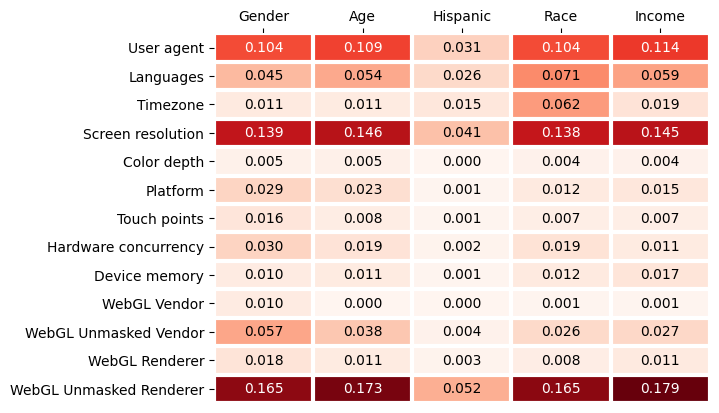

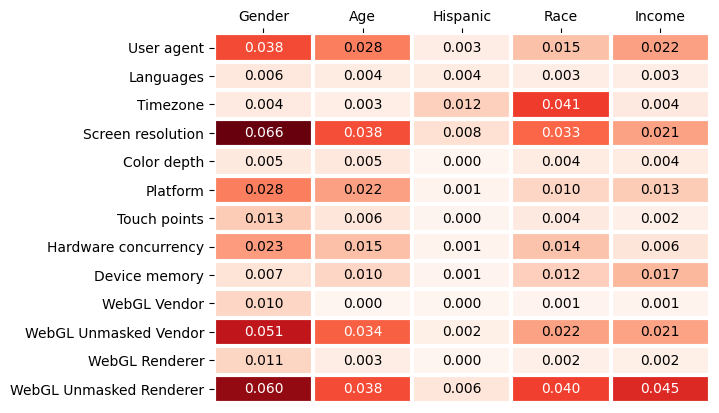

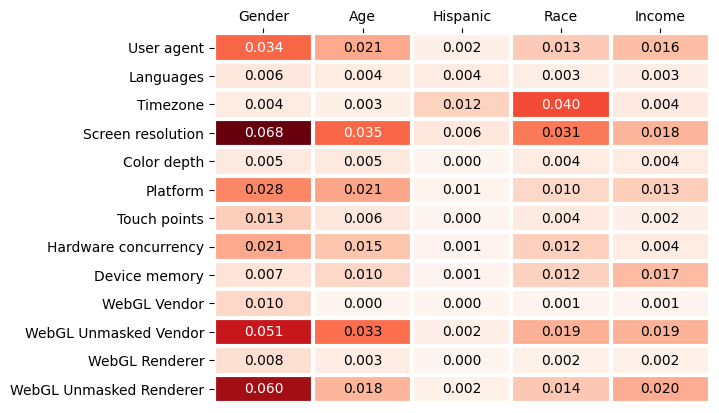

In [ ]:
ax = plot_mutual_info_heatmap(mutual_info_df_k1)
ax50 = plot_mutual_info_heatmap(mutual_info_df_k50)
ax100 = plot_mutual_info_heatmap(mutual_info_df_k100)

## Show results for normalized mutual information tables

In [ ]:
print('Normalized mutual information')
k=1
print('\nk=%s'%k)
mutual_info_df_k1_norm = get_mutual_info_df(sba_df, stable_ba_names, k, normalized=True)
display(mutual_info_df_k1_norm.round(3))
k=50
print('\nk=%s'%k)
mutual_info_df_k50_norm = get_mutual_info_df(sba_df, stable_ba_names, k, normalized=True)
display(mutual_info_df_k50_norm.round(3))
k=100
print('\nk=%s'%k)
mutual_info_df_k100_norm = get_mutual_info_df(sba_df, stable_ba_names, k, normalized=True)
display(mutual_info_df_k100_norm.round(3))

Normalized mutual information

k=1


,Distinct values,N,Gender,Age,Hispanic,Race,Income
Attribute,,,,,,,
User agent,434,8400,0.092,0.077,0.063,0.077,0.068
Languages,264,8400,0.040,0.038,0.053,0.053,0.035
Timezone,49,8400,0.010,0.008,0.031,0.046,0.011
Screen resolution,572,8400,0.123,0.104,0.082,0.103,0.086
Color depth,3,8400,0.004,0.004,0.000,0.003,0.002
Platform,12,8400,0.026,0.016,0.002,0.009,0.009
Touch points,11,8400,0.014,0.006,0.002,0.005,0.004
Hardware concurrency,24,8400,0.027,0.013,0.005,0.015,0.006
Device memory,7,8400,0.009,0.008,0.002,0.009,0.010



k=50


,Distinct values,N,Gender,Age,Hispanic,Race,Income
Attribute,,,,,,,
User agent,17,6741,0.034,0.020,0.006,0.011,0.013
Languages,3,7798,0.005,0.003,0.008,0.002,0.002
Timezone,7,8223,0.004,0.002,0.023,0.031,0.003
Screen resolution,25,6542,0.058,0.027,0.015,0.025,0.013
Color depth,3,8400,0.004,0.004,0.000,0.003,0.002
Platform,7,8377,0.025,0.015,0.002,0.008,0.008
Touch points,3,8312,0.011,0.004,0.001,0.003,0.001
Hardware concurrency,8,8185,0.020,0.011,0.002,0.011,0.004
Device memory,4,8318,0.006,0.007,0.001,0.009,0.010



k=100


,Distinct values,N,Gender,Age,Hispanic,Race,Income
Attribute,,,,,,,
User agent,12,6380,0.031,0.015,0.004,0.010,0.010
Languages,3,7798,0.005,0.003,0.008,0.002,0.002
Timezone,6,8146,0.003,0.002,0.023,0.030,0.003
Screen resolution,16,5972,0.060,0.025,0.011,0.022,0.011
Color depth,3,8400,0.004,0.004,0.000,0.003,0.002
Platform,6,8313,0.025,0.015,0.002,0.008,0.008
Touch points,3,8312,0.011,0.004,0.001,0.003,0.001
Hardware concurrency,6,8027,0.018,0.010,0.002,0.009,0.002
Device memory,4,8318,0.006,0.007,0.001,0.009,0.010


normalized for k=1


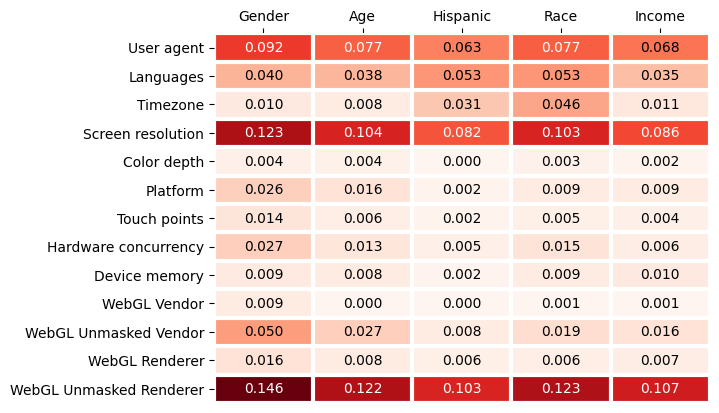

normalized for k=50


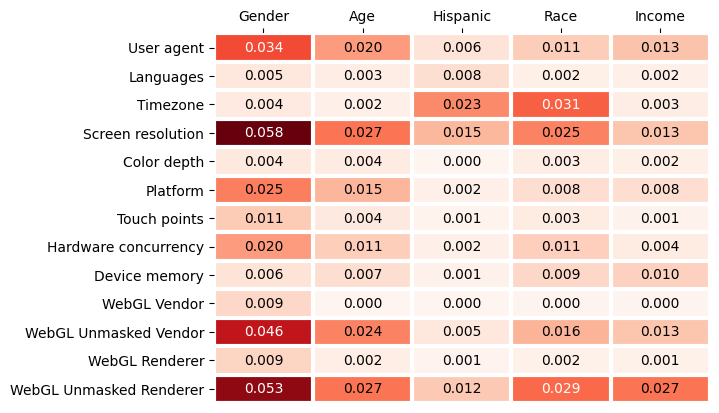

normalized for k=100


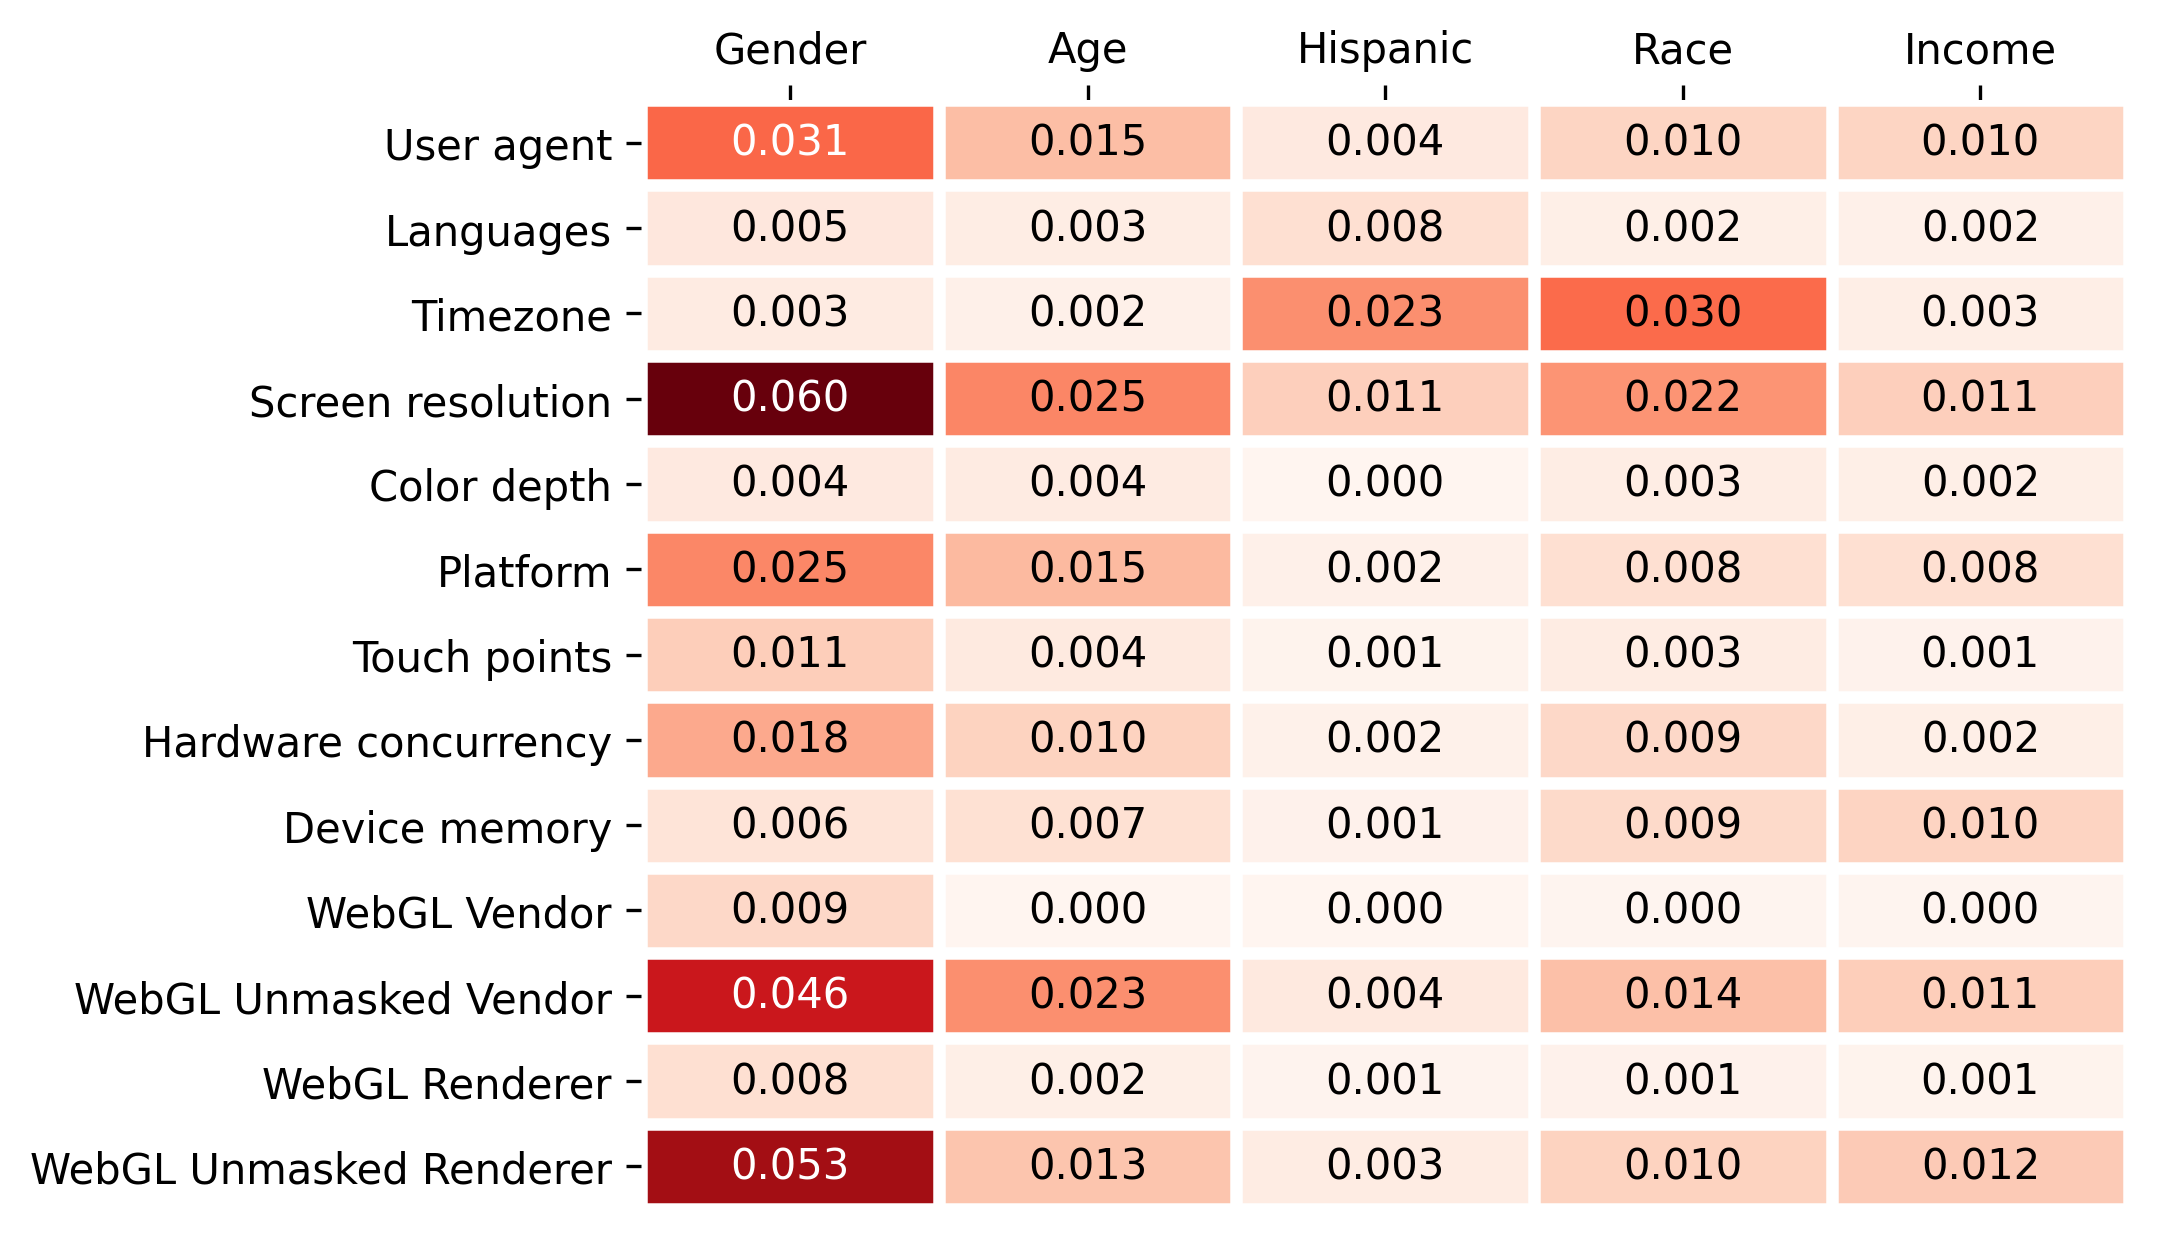

In [ ]:
print('normalized for k=1')
_ = plot_mutual_info_heatmap(mutual_info_df_k1_norm)
plt.show()
print('normalized for k=50')
_ = plot_mutual_info_heatmap(mutual_info_df_k50_norm)
plt.show()
print('normalized for k=100')
_ = plot_mutual_info_heatmap(mutual_info_df_k100_norm, dpi=300)

## Testing questions about normalization

Is it possible that normalization could enable the comparison of samples that have different demographic distributions? Or sample sizes? Or control for k?

We test this below by subsampling our data with a given (different) demographic distribution, computing normalized mutual information, and comparing.


The tests below are simple.

We only use Gender as the test. Original distribution of Gender category has {Male, Female, Other}.

We test 3 sample distributions:
1. Original
2. 50/50 Male/Female balanced (no Other)
3. 80/20 Male/Female imbalanced (no Other)

We use just Gender because it has a near 50/50 distribution in the underlying data and then provides for both the largest 80/20 and 50/50 samples, as well as allows comparing a distribution with 3 groups (Male/Female/Other) to 2 groups (Male/Female).

We test sizes with N in {1000, 2000, ..., 5000}

We repeat this for
- varying k:
  - k=1
  - k=50
- variations of normalized mutual information (NMI) and non-normalized:
  - $\frac{I(A;D)}{\sqrt{H(A)H(D)}}$
  - $\frac{I(A;D)}{H(D)}$
  - $I(A;D)$


To do this we first create the 3 distributions for N=5000

At each N we then randomly subsample from those distributions to compute the mutual information metrics.

The random sampling process creates noise. We handle this via repeated random sampling (100 times) and then collecting the mean and 95%CIs. Metrics are comparable if CIs overlap.

Make plots of metrics:

For each attribute (in some interesting subset of the attributes):

- x-axis: N
- y-axis: (normalized) mutual information

With lines for each of the 3 sample distributions

In [ ]:
D_name = 'Gender'
sba_df[D_name].value_counts()

Male      4227
Female    3990
Other      183
Name: Gender, dtype: int64

In [ ]:
import statsmodels.stats.api as sms


def get_mean_95CIs(vals):
  """Returns mean with 95% CIs: (mean, lower95%CI, upper95%CI). Assumes normal distribution."""
  return tuple([np.mean(vals)] + list(sms.DescrStatsW(vals).tconfint_mean(alpha=0.05)))

In [ ]:
random = 0

# Create the 3 sample distributions
dist_a_name = 'Original (Male,Female,Other)'
dist_b_name = '50/50 balanced (no Other)'
dist_c_name = '80/20 imbalanced (no Other)'
dist_names = [dist_a_name, dist_b_name, dist_c_name]

Ns = [1000, 2000, 3000, 4000, 5000]

sample_dist_dfs = {
    dist_a_name: sba_df.sample(8000, random_state=random, replace=False),
    dist_b_name: pd.concat([
      sba_df[sba_df['Gender']=='Female'].sample(2500, random_state=random, replace=False),
      sba_df[sba_df['Gender']=='Male'].sample(2500, random_state=random, replace=False),
    ]),
    dist_c_name: pd.concat([
      sba_df[sba_df['Gender']=='Female'].sample(1000, random_state=random, replace=False),
      sba_df[sba_df['Gender']=='Male'].sample(4000, random_state=random, replace=False),
  ])
}


repeated_samples = 100

def get_dist_n_I_dict(A_name, D_name, k, repeated_samples, verbose=False, **kwargs):
  """
  Returns for each distribution
  dist_n_i = {
    <dist>: {
      'resampled': [[I_r for repeat r] for each n in Ns],
      'mean': [mean_I_n for each n in Ns],
      'upperCI': [upperCI_I_n for each n in Ns],
      'lowerCI': [lowerCI_I_n for each n in Ns],
    }
    ...for each dist
  }
  """
  #if (normalized==False) and (normalized_b==False):
    #raise Exception('Either normalized or normalized_b parameter must be True')
  dist_n_I = {dist_name: {'resampled':[], 'mean': [], 'upperCI':[], 'lowerCI':[]} for dist_name in dist_names}
  for dist_name in dist_n_I.keys():
    s_dist_df = sample_dist_dfs[dist_name]
    s_dist_dict = {}
    for n in Ns:
      if verbose:
        print(dist, n)
      n_I_repeated = []
      for r in range(repeated_samples):
        s_df = s_dist_df.sample(n, random_state=random+r, replace=False)
        contingency_table = get_contingency_table(s_df, A_name, D_name)
        contingency_table = get_restricted_contingency_table(contingency_table, k=k)
        I = compute_mutual_information(contingency_table, **kwargs)
        n_I_repeated += [I]
      (n_mean, n_lowerCI, n_upperCI) = get_mean_95CIs(n_I_repeated)
      dist_n_I[dist_name]['resampled'] += [n_I_repeated]
      dist_n_I[dist_name]['mean'] += [n_mean]
      dist_n_I[dist_name]['lowerCI'] += [n_lowerCI]
      dist_n_I[dist_name]['upperCI'] += [n_upperCI]
  return dist_n_I


In [ ]:
# make plots for a few attributes
plt_attributes = stable_ba_names[:4]
print(plt_attributes)

['User agent', 'Languages', 'Timezone', 'Screen resolution']


In [ ]:
# without normalization

dist_n_I_dict_no_norm_k1 = {} # {attributes: dist_n_I_dict}
dist_n_I_dict_no_norm_k50 = {}
for i, A in enumerate(plt_attributes):
  print('%s: %s' % (i, A))
  dist_n_I_dict_no_norm_k1[A] = get_dist_n_I_dict(A, D_name, 1, repeated_samples)
  dist_n_I_dict_no_norm_k50[A] = get_dist_n_I_dict(A, D_name, 50, repeated_samples)

0: User agent
1: Languages
2: Timezone
3: Screen resolution


Mutual information without normalization


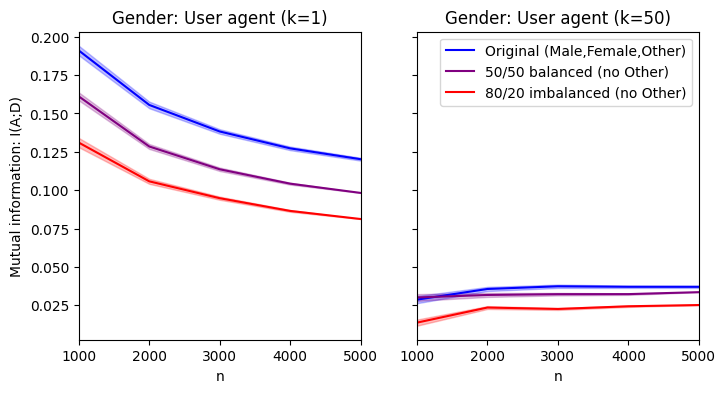

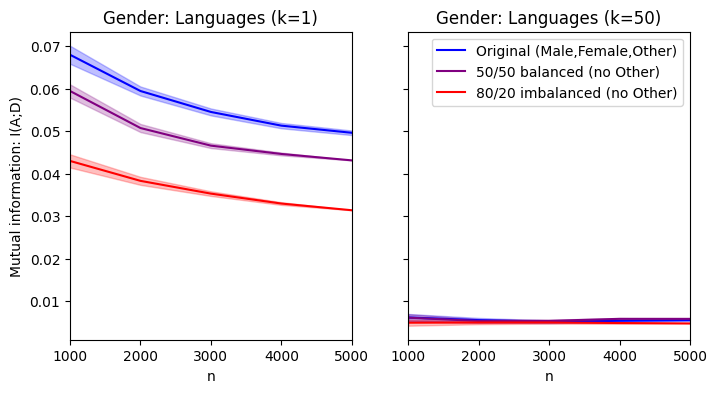

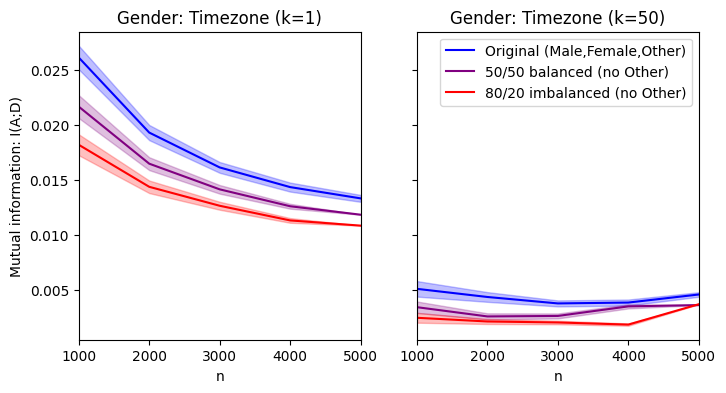

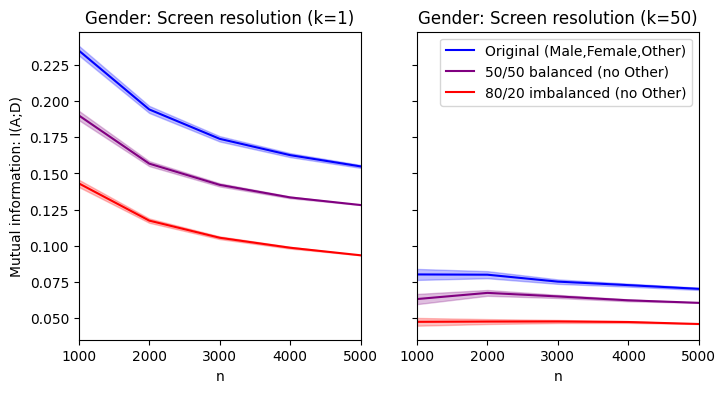

In [ ]:
colors = ['blue','purple','red']
print('Mutual information without normalization')

dist_n_I_dicts_k = {1: dist_n_I_dict_no_norm_k1, 50: dist_n_I_dict_no_norm_k50}

for ai, A in enumerate(plt_attributes):
  fig, axes = plt.subplots(1,2,figsize=(8,4), sharey=True, sharex=True)
  for ki, (k, dist_n_I_dict) in enumerate(dist_n_I_dicts_k.items()):
    ax = axes[ki]
    for di, dist_name in enumerate(dist_names):
      d_dict = dist_n_I_dict[A][dist_name]
      ax.plot(Ns, d_dict['mean'], label=dist_name, color=colors[di])
      ax.fill_between(Ns, d_dict['lowerCI'], d_dict['upperCI'], color=colors[di], alpha=0.25)
    ax.set_xlabel('n')
    ax.set_xlim(Ns[0], Ns[-1])
    _ = ax.set_title('%s: %s (k=%s)' % (D_name, A, k))
    if ki==0: ax.set_ylabel('Mutual information: I(A;D)')
  _ = ax.legend()

In [ ]:
# with normalization: I(A;D)/H(D)

dist_n_I_dict_norm_HD_k1 = {} # {attributes: dist_n_I_dict}
dist_n_I_dict_norm_HD_k50 = {}
for i, a in enumerate(plt_attributes):
  print('%s: %s' % (i, a))
  dist_n_I_dict_norm_HD_k1[a] = get_dist_n_I_dict(a, D_name, 1, repeated_samples, normalized=True)
  dist_n_I_dict_norm_HD_k50[a] = get_dist_n_I_dict(a, D_name, 50, repeated_samples, normalized=True)

0: User agent
1: Languages
2: Timezone
3: Screen resolution


Normalized Mutual information: I(A;D)/H(D)


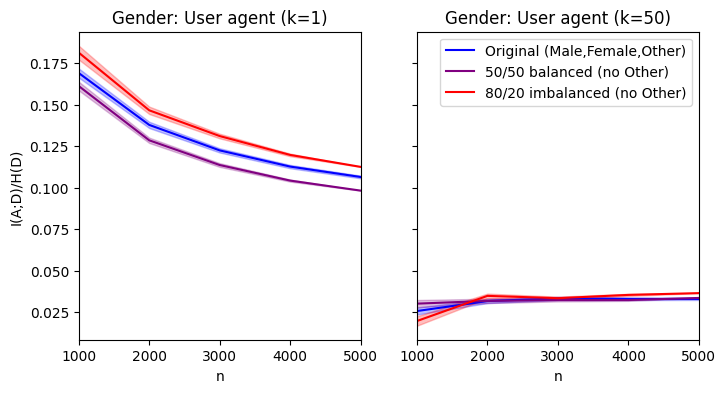

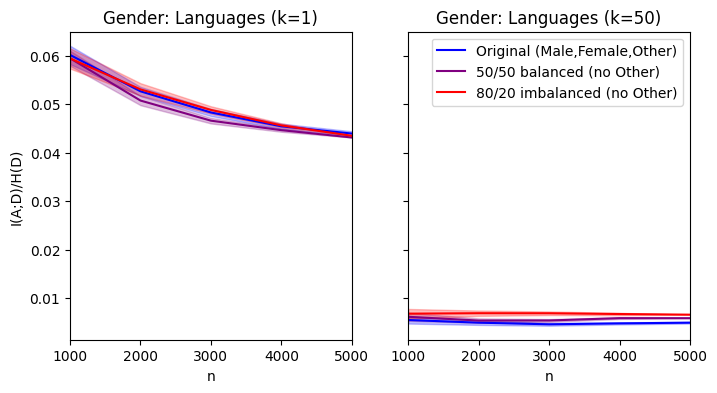

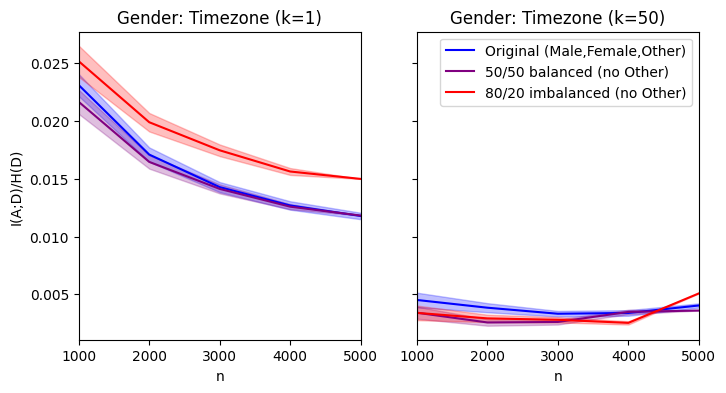

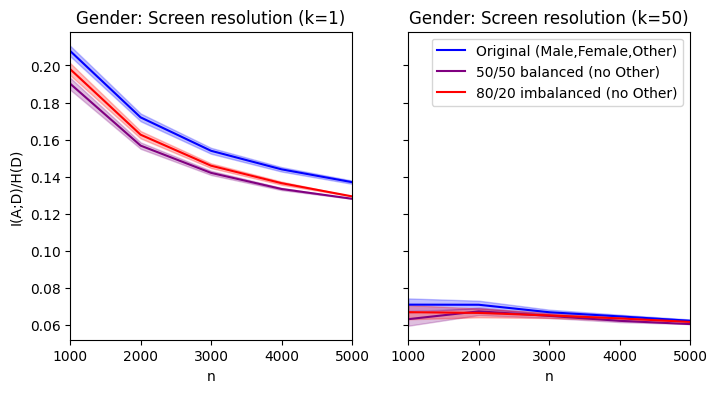

In [ ]:
colors = ['blue','purple','red']
print('Normalized Mutual information: I(A;D)/H(D)')

dist_n_I_dicts_k = {1: dist_n_I_dict_norm_HD_k1, 50: dist_n_I_dict_norm_HD_k50}

for ai, A in enumerate(plt_attributes):
  fig, axes = plt.subplots(1,2,figsize=(8,4), sharey=True, sharex=True)
  for ki, (k, dist_n_I_dict) in enumerate(dist_n_I_dicts_k.items()):
    ax = axes[ki]
    for di, dist_name in enumerate(dist_names):
      d_dict = dist_n_I_dict[A][dist_name]
      ax.plot(Ns, d_dict['mean'], label=dist_name, color=colors[di])
      ax.fill_between(Ns, d_dict['lowerCI'], d_dict['upperCI'], color=colors[di], alpha=0.25)
    ax.set_xlabel('n')
    ax.set_xlim(Ns[0], Ns[-1])
    _ = ax.set_title('%s: %s (k=%s)' % (D_name, A, k))
    if ki==0: ax.set_ylabel('I(A;D)/H(D)')
  _ = ax.legend()

In [ ]:
# with normalization: I(A;D)/sqrt(H(A)H(D))

dist_n_I_dict_norm_HAHD_k1 = {} # {attributes: dist_n_I_dict}
dist_n_I_dict_norm_HAHD_k50 = {}
for i, A in enumerate(plt_attributes):
  print('%s: %s' % (i, A))
  dist_n_I_dict_norm_HAHD_k1[A] = get_dist_n_I_dict(A, D_name, 1, repeated_samples, normalized_b=True)
  dist_n_I_dict_norm_HAHD_k50[A] = get_dist_n_I_dict(A, D_name, 50, repeated_samples, normalized_b=True)

0: User agent
1: Languages
2: Timezone
3: Screen resolution


Normalized Mutual information: I(A;D)/$\sqrt{H(A)H(D)}$


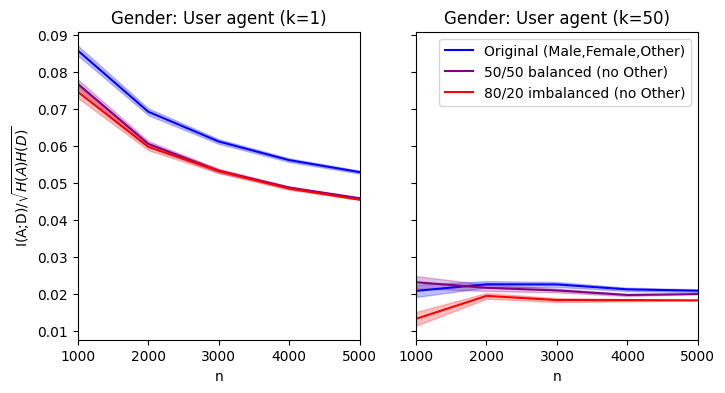

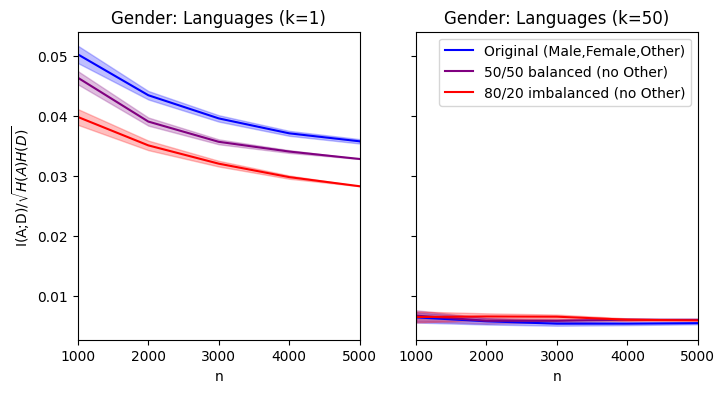

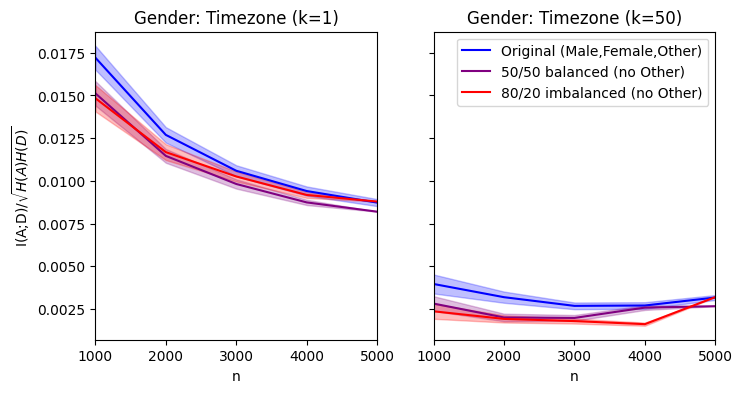

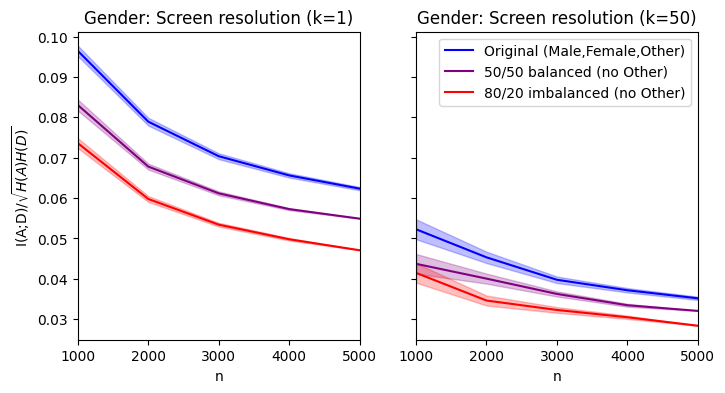

In [ ]:
print('Normalized Mutual information: I(A;D)/$\sqrt{H(A)H(D)}$')

dist_n_I_dicts_k = {1: dist_n_I_dict_norm_HAHD_k1, 50: dist_n_I_dict_norm_HAHD_k50}

for ai, A in enumerate(plt_attributes):
  fig, axes = plt.subplots(1,2,figsize=(8,4), sharey=True, sharex=True)
  for ki, (k, dist_n_I_dict) in enumerate(dist_n_I_dicts_k.items()):
    ax = axes[ki]
    for di, dist_name in enumerate(dist_names):
      d_dict = dist_n_I_dict[A][dist_name]
      ax.plot(Ns, d_dict['mean'], label=dist_name, color=colors[di])
      ax.fill_between(Ns, d_dict['lowerCI'], d_dict['upperCI'], color=colors[di], alpha=0.25)
    ax.set_xlabel('n')
    ax.set_xlim(Ns[0], Ns[-1])
    _ = ax.set_title('%s: %s (k=%s)' % (D_name, A, k))
    if ki==0: ax.set_ylabel('I(A;D)/$\sqrt{H(A)H(D)}$')
  _ = ax.legend()

### Another test about normalization

Idea: For a given N=1800, compare NMI values for original distribution vs when each demographic category has a balanced distribution with an equal number of users in each group.



In tests below we:
- Compute separately for each demographic category, D:
  - Create a random subsample of N=1800, equally split across demo groups in D
  - Get the normalized mutual info df for just that D
- Merge normalized mutual info dfs for all the D's

When doing this we leave out Gender:Other and Income:Prefer not to say.

So in order to make a better comparison, we first recompute the normalized MI for the sample after dropping rows with either Gender:Other or Income:Prefer not to say

N=1800
normalized for k=1


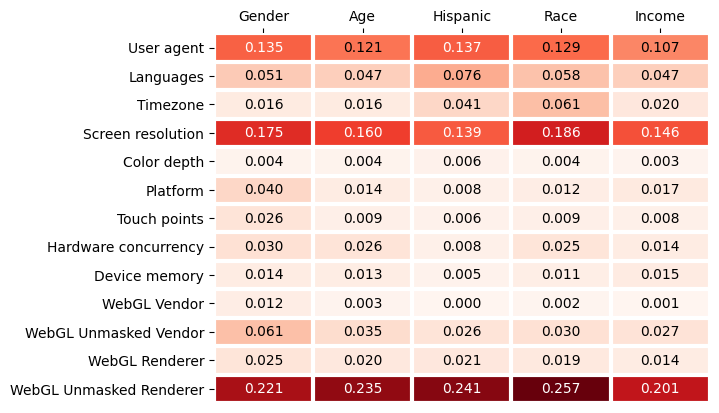

normalized for k=50


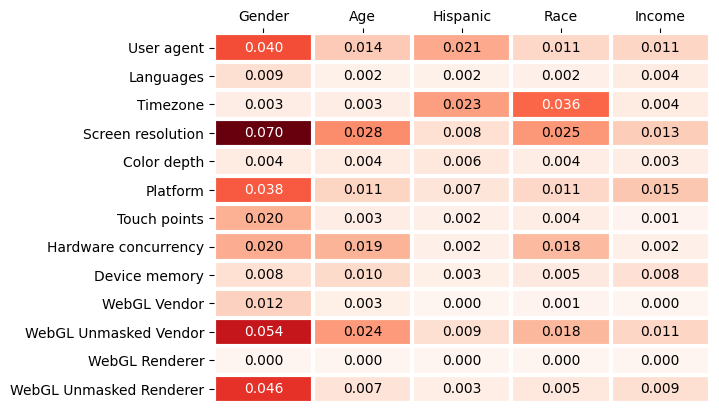

In [ ]:
# Make comparison: subsample dropping Gender:Other and Income:Prefer not to say
# Compute NMI for k=50

random = 0

ss_df = sba_df[(sba_df['Gender']!='Other') & (sba_df['Income']!='Prefer not to say')].sample(1800, random_state=random).copy()
print('N=%s' % len(ss_df))
print('normalized for k=1')
_ = plot_mutual_info_heatmap(get_mutual_info_df(ss_df, stable_ba_names, 1, normalized=True))
plt.show()
print('normalized for k=50')
_ = plot_mutual_info_heatmap(get_mutual_info_df(ss_df, stable_ba_names, 50, normalized=True))
plt.show()

In [ ]:
# Ignore Gender:Other and Income:Prefer not to say because these groups are small. This will impact the test
norm_test_Ds = {
    'Gender': ['Male', 'Female'],
    'Age': ['18 - 34 years', '35 - 54 years', '55 or older'],
    'Hispanic': ['Yes', 'No'],
    'Race': ['White', 'Black', 'Asian', 'Other or mixed'],
    'Income': ['Less than $50,000', '$50,000 - $99,999', '$100,000 or more']
}
norm_test_Ds

{'Gender': ['Male', 'Female'],
 'Age': ['18 - 34 years', '35 - 54 years', '55 or older'],
 'Hispanic': ['Yes', 'No'],
 'Race': ['White', 'Black', 'Asian', 'Other or mixed'],
 'Income': ['Less than $50,000', '$50,000 - $99,999', '$100,000 or more']}

In [ ]:
"""
Compute separately for each demographic category, D:
- Create a random subsample of N=1800, equally split across demo groups in D
- Get the normalized mutual info df for just that D
Merge normalized mutual info dfs for all the D's
"""
random=0
N = 1800 # chosen because it is divisible by 4, 3, 6. Larger would not have enough of every demo if using equal proportions.

def get_normalized_mutual_info_equal_demos(df=sba_df, N=1800, Ds=norm_test_Ds, k=50):
  ss_norm_mi_dfs = {}
  for D, demos in Ds.items():
    # Get subsample for D
    n = int(N/len(demos))
    ss_dfs = [df[df[D]==demo].sample(n, random_state=random, replace=False) for demo in demos]
    ss_df = pd.concat(ss_dfs)
    ss_norm_mi_dfs[D] = get_mutual_info_df(ss_df, stable_ba_names, k, Ds=[D], normalized=True)[[D]]
  return pd.DataFrame({D: mi_df[D] for (D, mi_df) in ss_norm_mi_dfs.items()})

Normalized mutual information (NMI) where NMI calculated separately for each demographic category, after subsampling with equal groups in each category.
k=1


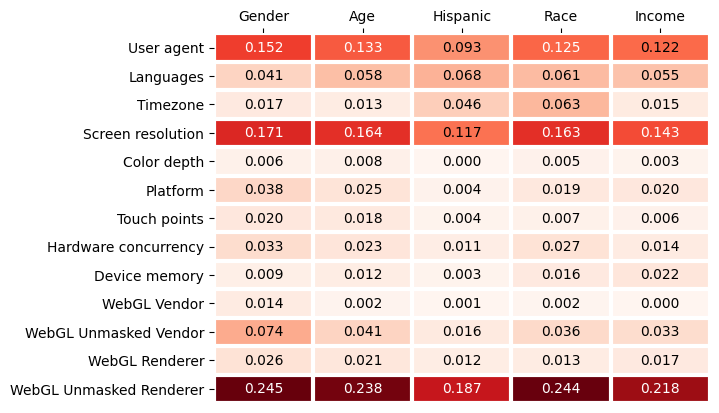

k=25


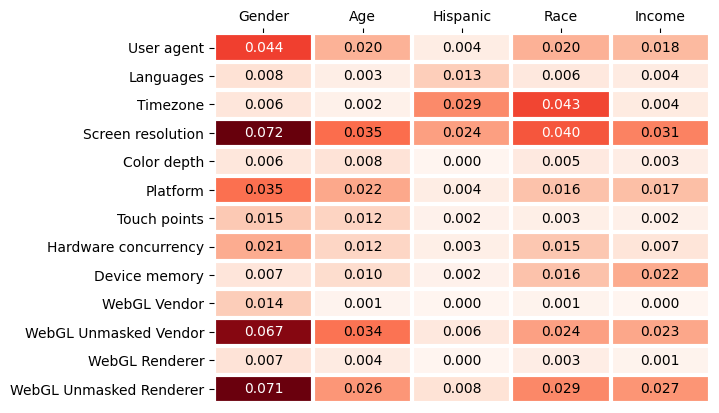

k=50


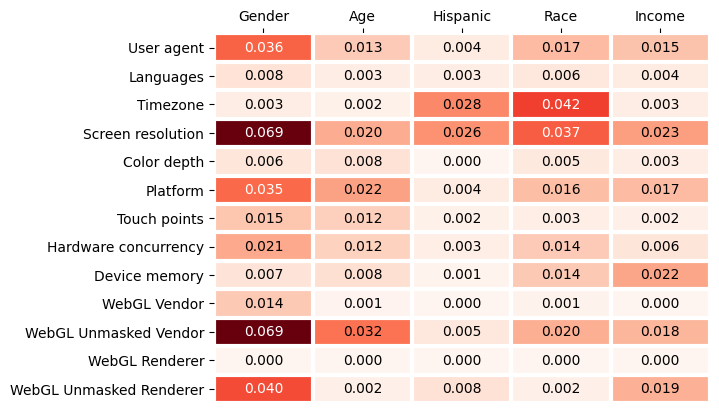

In [ ]:
print('Normalized mutual information (NMI) where NMI calculated separately for each demographic category, after subsampling with equal groups in each category.')
for k in [1, 25, 50]:
  ss_norm_mi_k = get_normalized_mutual_info_equal_demos(df=sba_df, N=1800, Ds=norm_test_Ds, k=k)
  print('k=%s'%k)
  plot_mutual_info_heatmap(ss_norm_mi_k, dpi=100)
  plt.show()
  #display(ss_norm_mi_k.round(3))